### Credit Card Fraud Detection

###### Objective: The goal of this task is to detect fraudulent credit card transactions from a highly imbalanced dataset. Fraud cases are rare, so special handling of class imbalance and careful evaluation metrics are required.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
#loading the data 
df = pd.read_csv("C:\\Users\\bbuser\\Downloads\\creditcard.csv")  
print("Shape:", df.shape)
print(df.info())
print(df.describe())



Shape: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  flo

Class
0    284315
1       492
Name: count, dtype: int64


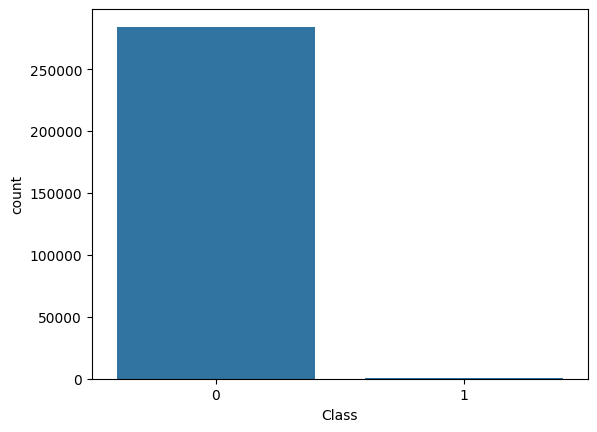

In [4]:
#EDA
print(df["Class"].value_counts())
sns.countplot(x="Class", data=df)
plt.show()

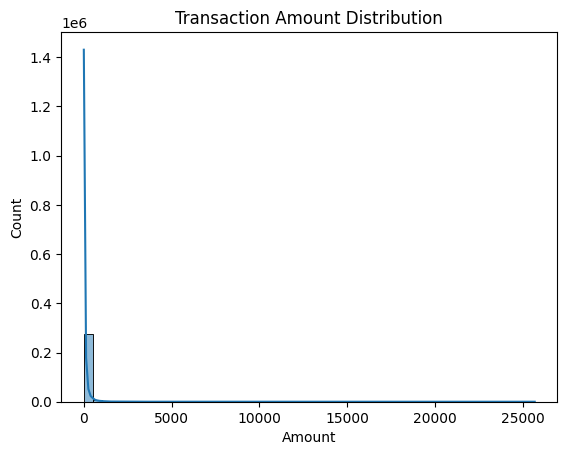

In [5]:
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

In [6]:
#Data Preprocessing
x = df.drop(columns=['Class'])
y = df['Class']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)


In [8]:
#Baseline Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test)[:, 1]
    else:
        y_prob = model.predict(x_test)

    cm = confusion_matrix(y_test, np.round(y_pred))
    print(f"{name} Confusion Matrix:\n", cm)

    print(f"{name} Report:\n", classification_report(y_test, np.round(y_pred)))

    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name} ROC-AUC: {auc:.4f}")

    results[name] = auc

    


Linear Regression Confusion Matrix:
 [[56855     9]
 [   55    43]]
Linear Regression Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.44      0.57        98

    accuracy                           1.00     56962
   macro avg       0.91      0.72      0.79     56962
weighted avg       1.00      1.00      1.00     56962

Linear Regression ROC-AUC: 0.9800
Random Forest Confusion Matrix:
 [[56861     3]
 [   19    79]]
Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.81      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest ROC-AUC: 0.9380
Decision Tree Confusion Matrix:
 [[56830    34]
 [   20    78]]
Decision Tree Report:
              

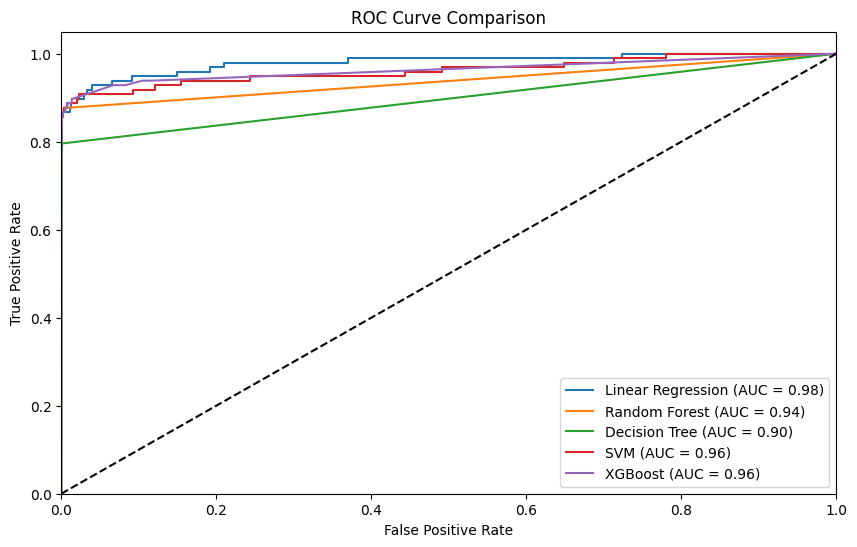

In [10]:
# ROC Curve comparison
plt.figure(figsize=(10, 6))
from sklearn.metrics import roc_curve, auc

for name, model in models.items():
    # Use predict_proba if available, else normalize predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test)[:, 1]
    else:
        y_pred = model.predict(x_test)
        # Min-max normalization for regression outputs
        y_prob = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

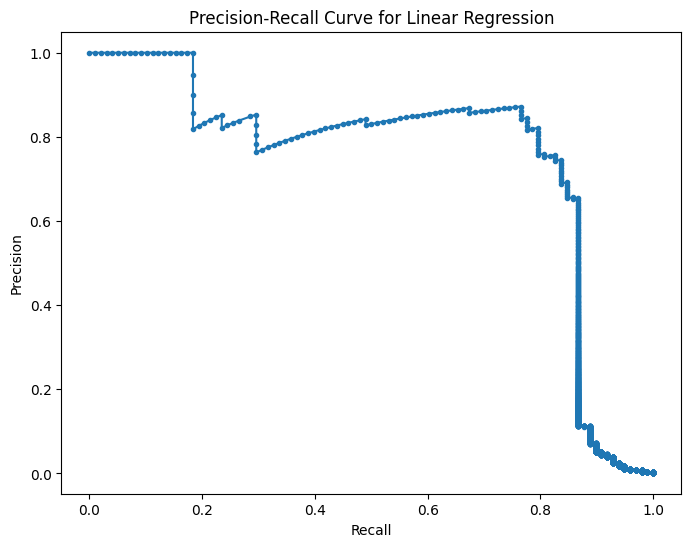

In [12]:
# precision recall curve for the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
if hasattr(best_model, "predict_proba"):
	y_prob = best_model.predict_proba(x_test)[:, 1]
else:
	y_pred = best_model.predict(x_test)
	# Min-max normalization for regression outputs
	y_prob = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve for {best_model_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
